In [2]:
##### Ще създадем модели, които се опитват да обяснят данните
import statsmodels.api as sm # съдържа методи за линейна регресия, логистична регресия и др.
import statsmodels.formula.api as smf
import statsmodels.graphics.api as smg
import patsy # не е нужно да внасяме (съдържа се в statsmodels), но за демонстрация; може да се ползва напр. със scikit-learn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

In [2]:
# Тук въвеждаме данните, които ще използваме в примерите
y = np.array([1, 2, 3, 4, 5])
x1 = np.array([6, 7, 8, 9, 10])
x2 = np.array([11, 12, 13, 14, 15])

In [3]:
##### Разглеждаме линейния модел Y = b_0 + b_1*X_1 + b_2*X_2 + b_3*X_1*X_2, където наблюдаваните стойности са y, x_1, x_2
# y = X*beta + еrr, където y, beta и err са вектори, X_ij е стойност на x за y_i и beta_j (вж. f.366 за подробности)
# the design matrix for the right-hand side is X = [1 x_1 x_2 x_1*x_2]
# уравнението се записва във вида y = X*beta, err са съответните residues
X = np.vstack([np.ones(5), x1, x2, x1*x2]).T # транспонираме получената от vstack() матрица
# vstack нарежда редовете вертикално един под друг, а нам е необходима транспонираната матрица
X
# Решаваме системата уравнения y = X*b + eps, която в този случай е преопределена. Използваме np.linalg.lstsq(X, y),
# който в този случай дава решение по метода на least-square fit
beta, res, rank, sval = np.linalg.lstsq(X, y, rcond=None) # решения, сума на резидуумите, ранг на X, singular values на X
beta
#rank   # обикновено ни трябва само решението, в случая това е векторът със стойностите на b_0,1,2,3
#sval
#res
# ВИЖ ПРИМЕРА В help doc-а!
#help(np.linalg.lstsq)
#
# Това е доста прост пример, а използваната функция е low level.

array([-5.55555556e-01,  1.88888889e+00, -8.88888889e-01, -8.88900666e-16])

In [4]:
###### Същия пример с Patsy и dmatrices. Синтаксисът на Patsy формулите е по-особен.
data = {"y": y, "x1": x1, "x2": x2} # съответният набор данни се дава с dictionary
y, XX = patsy.dmatrices("y ~ 1 + x1 + x2 + x1*x2", data) # XX е design matrix, същата като X по-горе
y
XX # така директно получаваме design matrix (без да я съставяме), която вече можем да вкараме в някоя функция от statsmodels
#
# Можем да използваме DataFrame, за да посочим данните, а също и да получим матрицата XX като DataFrame
df_data = pd.DataFrame(data) # дава грешка, иначе можеше да го сложим като аргумент долу вместо data
y, XX = patsy.dmatrices("y ~ 1 + x1 + x2 + x1:x2", data, return_type="dataframe") #ПРИ КОМПИЛИРАНЕ САМО НА КЛЕТКАТА - ГРЕШКА
#
# ако искаме да направим ordinary linear regression, използваме класа OLS и метода fit
#model = sm.OLS(y, XX) # класът OLS returns a class instance that represents the model
#result = model.fit() # fit the model to the data in the design matrix we use the fit method, which returns a result object 
#result.params # получаваме параметрите, от регресията b_0,1,2,3

# може да използваме statsmodels.formula.API; е даваме y и X, а само Patsy формула и dictionary (DataFrame) с данните
model = smf.ols("y ~ 1 + x1 + x2 + x1:x2", df_data) 
result = model.fit()
result.params



Intercept   -5.555556e-01
x1           1.888889e+00
x2          -8.888889e-01
x1:x2       -1.110223e-15
dtype: float64

In [5]:
### Примери за синтаксиса на Patsy формулите. ТУК а, b и т.н. СА ПРОМЕНЛИВИ КАТО y, x1, x2 !!!
from collections import defaultdict
data = defaultdict(lambda: np.array([]))

patsy.dmatrices("y ~ a", data=data)[1].design_info.term_names #.design_info.term_names дава променливите [1]-дясно, [2]-ляво y
patsy.dmatrices("y ~ 1 + a + b", data=data)[1].design_info.term_names # (нищо)+1 включва (им)експлицитно Intercept
patsy.dmatrices("y ~ -1 + a + b", data=data)[1].design_info.term_names # изключва Intercept
patsy.dmatrices("y ~ a * b", data=data)[1].design_info.term_names
patsy.dmatrices("y ~ a * b * c", data=data)[1].design_info.term_names # в Numerical Python има още примери
patsy.dmatrices("y ~ a * b * c - a:b:c", data=data)[1].design_info.term_names # премахване на specific term
#patsy.dmatrices("y ~ I(a + b)", data=data)[1].design_info.term_names # показваме зависимост от сумата на двете променливи
#patsy.dmatrices("y ~ I(a**2)", data=data)[1].design_info.term_names # дават ГРЕШКА
patsy.dmatrices("y ~ a*a", data=data)[1].design_info.term_names # горното показва зависимост от а^2, а това е само от a.

#patsy.dmatrices("y ~ np.log(a) + b", data=data)[1].design_info.term_names # други начини за трансформиране на променливи

#z = lambda x1, x2: x1+x2  # но пак дават ГРЕШКА
#patsy.dmatrices("y ~ z(a, b)", data=data)[1].design_info.term_names

#### Примери с Categorical Variables. Patsy автоматично превръща всичко освен float и int в дискретни числени dummy variables
### Ако искаме някоя int променлива да е категорийна, използваме нотация C(x)
data = {"y": [1, 2, 3], "a": [5, 6, 7]}
patsy.dmatrices("y ~ - 1 + a", data=data, return_type="dataframe")[1] # е различно от 
patsy.dmatrices("y ~ - 1 + C(a)", data=data, return_type="dataframe")[1]

# Variables with non-numerical values are automatically interpreted and treated as categorical values:
data = {"y": [1, 2, 3], "a": ["type A", "type B", "type C"]}
patsy.dmatrices("y ~ - 1 + a", data=data, return_type="dataframe")[1]

# to encode the categorical variables with orthogonal polynomials instead of treatment indicators, we can use C(a, Poly)
patsy.dmatrices("y ~ - 1 + C(a, Poly)", data=data, return_type="dataframe")[1] # НЕПОЗНАТО!!!

,"C(a, Poly).Constant","C(a, Poly).Linear","C(a, Poly).Quadratic"
0,1.0,-7.071068e-01,0.408248
1,1.0,-4.433780e-17,-0.816497
2,1.0,7.071068e-01,0.408248


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.360
Model:                            OLS   Adj. R-squared:                  0.347
Method:                 Least Squares   F-statistic:                     27.30
Date:                Wed, 15 Dec 2021   Prob (F-statistic):           3.94e-10
Time:                        16:39:11   Log-Likelihood:                -267.12
No. Observations:                 100   AIC:                             540.2
Df Residuals:                      97   BIC:                             548.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1162      0.363      0.320      0.7

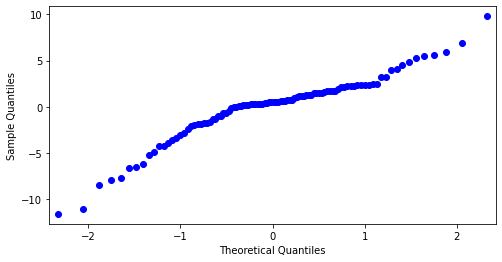

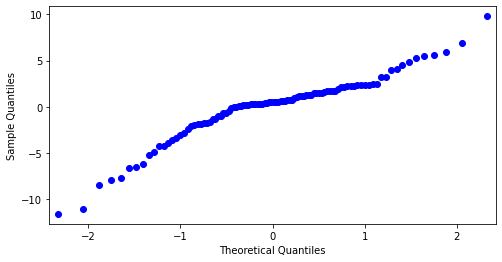

In [6]:
############# LINEAR REGRESSION със statsmodels и statsmodels.formula  вж. f.343 от Numerical Python
# Разглеждаме модел y = 1+2*x1+3*x2+4*x1*x2; Първо ще сложим данните в DataFrame
N = 100
x1 = np.random.randn(N) # 100 сучайни числа
x2 = np.random.randn(N)
data = pd.DataFrame({"x1": x1, "x2": x2})
data["y_true"] = 1 + 2 * x1 + 3 * x2 + 4 * x1 * x2 # това е истинската стойност на y, но ще симулираме експеримент като...

e = 0.5 * np.random.randn(N) #... създаваме гаусово разпределен шум и го добавяме към y
data["y"] = data["y_true"] + e # ще работим с тези числа уж сме ги получили от експеримент

## разглеждаме модел с две независими променливи x1 и x2, като все още не знаем каква е зависимостта. Започваме с най-простия
# случай y = b0+b1*x1+b2*x2, което в Patsy е "y ~ x1 + x2"

# fit the model to the data using ordinary linear square, for which we use the smf.ols class
model = smf.ols("y ~ x1 + x2", data) # Create an instance of model class; "model" е името на модела (лошо решение, но туй то)
result = model.fit() # invoke the fit method 

print(result.summary()) # можем да научим доста неща от таблицата, но и някои, които не ни трябват
result.rsquared # друг начин за показване само на R-squared; повече за таблицата на f. 345

result.resid.head() # the residuals of the model fit to the data; проверяваме доколко те са нормално разпределени чрез тест:
z, p = stats.normaltest(result.fittedvalues.values) # хипотезен тест за нормалност, output Z съответната p-value
(z, p) # ако p е малкo, можем да отхвърлим нулевата хипотеза, че резидиумите са нормално разпределени

fig, ax = plt.subplots(figsize=(8, 4)) # графична проверка можем да направим и с QQ плот; тук приготвяме размера и оста
smg.qqplot(result.resid, ax=ax) # в нашия случай графиката не е линейна (не е учудващо)

# This suggests that the observed residuals are unlikely to be a sample of a normal-distributed random variable. 
# These indicators provide evidence that the model that we use is not sufficient, and we need to refine the model.
# We include the missing interaction term by adding it to the Patsy formula and repeat the previous steps.


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     2951.
Date:                Wed, 15 Dec 2021   Prob (F-statistic):           2.27e-94
Time:                        16:39:12   Log-Likelihood:                -62.698
No. Observations:                 100   AIC:                             133.4
Df Residuals:                      96   BIC:                             143.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9825      0.049     20.210      0.0

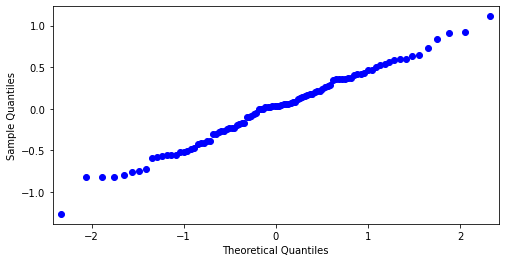

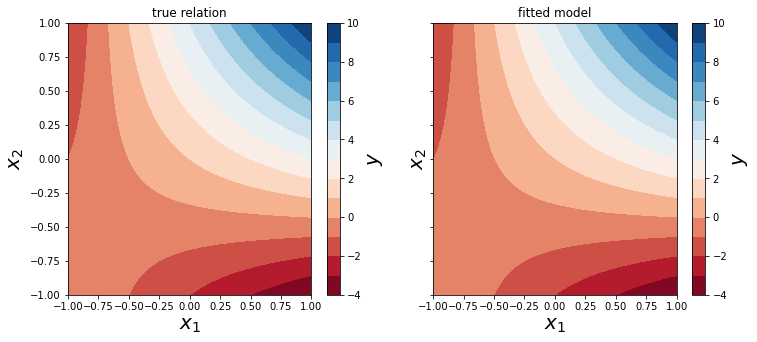

In [7]:
# Продължаваме с вече подобрения модел, където сме включили взаимодействието x1*x2. Другото е същото като по-горе.
model = smf.ols("y ~ x1 + x2 + x1*x2", data) # Create an instance of model class
result = model.fit() # invoke the fit method

print(result.summary()) # Познатата ни голяма таблица. Този път R-squared е доста голямо
result.rsquared # Винаги можем да увеличим R-squared като добавям нови членове, но рискуваме да overfit-ваме модела като го
# натоварим с членове с low predictive power (small coefficient and high corresponding p-value)

z, p = stats.normaltest(result.fittedvalues.values) # затова просто ще тестваме за нормалност резидиумите
p

fig, ax = plt.subplots(figsize=(8, 4)) # изследваме графично нормалност на резидиумите чрез QQ плот
smg.qqplot(result.resid, ax=ax) # доста по-линейна от горната

result.params # след като вече сме доволни от модела, просто вземаме параметрите b0, b1, b2, b3

### Можем да предскажем поведението на модела при други стойности на x1 и x2 чрез predict метода
x = np.linspace(-1, 1, 50)
X1, X2 = np.meshgrid(x, x) # правим DataFrame със стойностите на x1 and x2, за който ще предсказваме y value
new_data = pd.DataFrame({"x1": X1.ravel(), "x2": X2.ravel()}) # функцията ravel() прави едномерен ред от многомерен

y_pred = result.predict(new_data) # използваме predict методa върху result = model.fit()
# получаваме NumPy array (vector) със същата дължина като data vectors X1 и X2

### Ако искаме да го покажем графично, първо трябва да променим размера и формата на y_pred
#y_pred.shape # това в момента е формата на y_pred
y_pred = y_pred.values.reshape(50, 50) # това е в съответствие с размерите на X1 и X2; само y_pred.reshape дава грешка

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)  # ще построим графиките както следва:
def plot_y_contour(ax, Y, title):
    c = ax.contourf(X1, X2, Y, 15, cmap=plt.cm.RdBu)
    ax.set_xlabel(r"$x_1$", fontsize=20)
    ax.set_ylabel(r"$x_2$", fontsize=20)
    ax.set_title(title)
    cb = fig.colorbar(c, ax=ax)
    cb.set_label(r"$y$", fontsize=20)

### y_true досега не е дефинирана като отделен израз, чиято стойност можем да изчислим върху X1 и X2
y_true = 1 + 2 * X1 + 3 * X2 + 4 * X1 * X2 # наложи се да се направят корекции и добавка към кода в книгата на f.349
y_true = y_true.reshape(50, 50)

plot_y_contour(axes[0], y_true, "true relation") # contour graphs of the true model... ДАВА ГРЕШКА: y_true not defined
plot_y_contour(axes[1], y_pred, "fitted model") # ... and the fitted model

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   cons    30 non-null     float64
 1   income  30 non-null     int64  
 2   price   30 non-null     float64
 3   temp    30 non-null     int64  
dtypes: float64(2), int64(2)
memory usage: 1.1 KB
                                 OLS Regression Results                                
Dep. Variable:                   cons   R-squared (uncentered):                   0.986
Model:                            OLS   Adj. R-squared (uncentered):              0.985
Method:                 Least Squares   F-statistic:                              1001.
Date:                Wed, 15 Dec 2021   Prob (F-statistic):                    9.03e-27
Time:                        23:52:02   Log-Likelihood:                          51.903
No. Observations:                  30   AIC:                                     -99.81
Df Residua

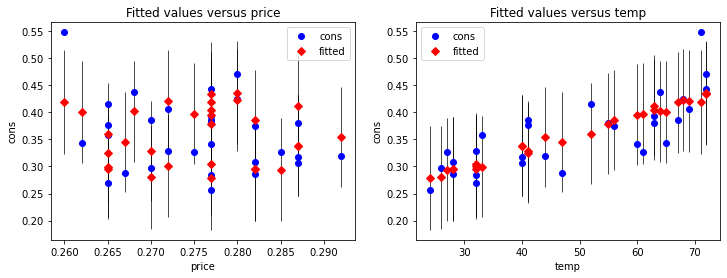

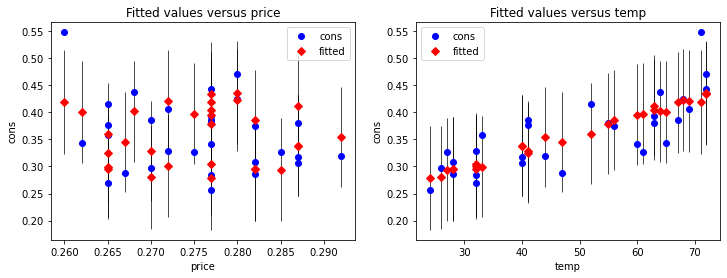

In [3]:
#### EXAMPLE DATASETS
# Можем да изтеглим разнообразни datasets чрез get_rdataset функцията от модула sm.datasets.
# Функцията get_rdataset използва името на dataset и евентуално името на пакета.
dataset = sm.datasets.get_rdataset("Icecream", "Ecdat") # зареждаме данни Icecream от пакета Ecdat; наричаме dataset-a "dataset"
dataset.title # дава името на датасета "Ice Cream Consumption"
dataset.data.info() # информация за съдържанието: брой колони и вид данни

### Можем да fit този dataset към статистически модели по познатата процедура, например consumption като линеен модел
# с price и temperature като независими променливи.
model = smf.ols("cons ~ -1 + price + temp", data=dataset.data) # без свободен член
result = model.fit()

print(result.summary()) # познатата ни голяма таблица за descriptive statistics, но тук ще използваме друго

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4)) # ще подходим графично и показваме фитнатите vs истински стойности
smg.plot_fit(result, 0, ax=ax1) # използваме функцията plot_fit
smg.plot_fit(result, 1, ax=ax2)

# Вижда се от графиката, че зависимостта на connsumation от temperature е почти линейна, но няма определена зависимост от
# price (може би защото price range е малък). Това не си личи от таблицата! 